# メイン2

## 昨日のレース結果を更新する

In [1]:
# 最新のレース結果をダウンロードする
import download_race_data as dl_race
import importlib
import datetime as dt
importlib.reload(dl_race)

# start_date = dt.datetime.strptime('2022-11-01', '%Y-%m-%d')
start_date = dt.datetime.strptime('2023-01-01', '%Y-%m-%d')

yesterday_date = dt.datetime.now() - dt.timedelta(1)
dl_race.download_race_data(start_date, yesterday_date)

# テストを実行
dl_race.test()

# テーブルを作成
import create_tables
importlib.reload(create_tables)

# data_tables = create_tables.DataTables.create_with_update() # need_update (最新のtxtを既存のpickleのテーブルをくっつける)
data_tables = create_tables.DataTables.create_with_all_update() # テーブル構造を変えたときや一番はじめはこっちを実行

# テストを実行
data_tables.test()


http://www1.mbrace.or.jp/od2/K/202301/k230108.lzh をダウンロードしました
http://www1.mbrace.or.jp/od2/K/202301/k230109.lzh をダウンロードしました
http://www1.mbrace.or.jp/od2/K/202301/k230110.lzh をダウンロードしました
http://www1.mbrace.or.jp/od2/B/202301/b230108.lzh をダウンロードしました
http://www1.mbrace.or.jp/od2/B/202301/b230109.lzh をダウンロードしました
http://www1.mbrace.or.jp/od2/B/202301/b230110.lzh をダウンロードしました
C:\Users\every\Documents\python\kyotei-ai2\results_txt/k230108.lzh を解凍しました
C:\Users\every\Documents\python\kyotei-ai2\results_txt/k230109.lzh を解凍しました
C:\Users\every\Documents\python\kyotei-ai2\results_txt/k230110.lzh を解凍しました
C:\Users\every\Documents\python\kyotei-ai2\results_bangumi_txt/b230108.lzh を解凍しました
C:\Users\every\Documents\python\kyotei-ai2\results_bangumi_txt/b230109.lzh を解凍しました
C:\Users\every\Documents\python\kyotei-ai2\results_bangumi_txt/b230110.lzh を解凍しました
download_race_data: テスト成功
レーサーの過去生成データテーブルの作成


100%|████████████████████████████████████████████████████████████████████████████| 1682/1682 [1:30:32<00:00,  3.23s/it]


create_tables:テスト成功


In [680]:
# テーブルを表示確認
# data_tables.merged_t

## 一時的な関数

In [12]:
import utils
importlib.reload(utils)
import optuna.integration.lightgbm as lgb_o
import optuna
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import pandas as pd

PIC_FILE_NAME = "pic_optuna_params.pickle"
TMP_PIC_FILE_NAME = "pic_optuna_params_tmp.pickle"

import model_evaluator as mev
importlib.reload(mev)

class LGBM_Model:
    def __init__(self, params, X_train, y_train, X_test, y_test):
        lgb_clf = lgb.LGBMClassifier(**params)
        lgb_clf.fit(X_train.values, y_train.values)
        
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.lgb_clf = lgb_clf
        self.mev = mev.ModelEvaluator(lgb_clf)
        
    def get_predict_proba(self):
        return self.mev.predict_proba(self.X_test, std=True)
    
    def get_pred_table(self):
        return self.mev.pred_table(self.X_test, 0.5, False)

    def get_feature_importance(self):
        return self.mev.feature_importance(self.X_test)
        

class LGBM_Models:
    def __init__(self, race_d, opt_params_df):
        self.opt_params_df = opt_params_df
        
        models = {}
        for i,v in opt_params_df.iterrows():
            params = v.to_dict()
            
            stadium_code = i.split('_')[0]
            target_variable = i.split('_')[1]
            X_train, y_train, X_test, y_test = LGBM_Models.split(race_d, stadium_code, target_variable)
            
            model = LGBM_Model(params, X_train, y_train, X_test, y_test)
            
            models[i] = model
            
        self.models = models
        
    # 出走データからpredテーブルを戻す
    def get_syusso_pred_table(self, syusso_d, stadium_code):
        pred_r1 = self.models[stadium_code+'_rank1'].mev.pred_table(syusso_d, 0, False)
        pred_r3 = self.models[stadium_code+'_rank3'].mev.pred_table(syusso_d, 0, False)
        return pred_r1, pred_r3
    
    @classmethod
    def create_from_pickle(cls, race_d):
        df = pd.read_pickle(PIC_FILE_NAME)
        return cls(race_d, df)
    
    @classmethod
    def create_from_temp_pickle(cls, race_d):
        df = pd.read_pickle(TMP_PIC_FILE_NAME)
        return cls(race_d, df)
    
    @classmethod
    def create_temp(cls, race_d, stadium_codes):
        df = LGBM_Models.create_lgb_params_table(race_d, stadium_codes)
        df.to_pickle(TMP_PIC_FILE_NAME)
        return cls(race_d, df)
    
        
    @classmethod
    def create_init(cls, race_d):
        stadium_codes = utils.stadium_list.keys()
        df = LGBM_Models.create_lgb_params_table(race_d, stadium_codes)
        df.to_pickle(PIC_FILE_NAME)
        return cls(race_d, df)
    
    @staticmethod
    def split(race_d, stadium_code, target_variable_name):
        filtered_race_d = utils.filter_stadium(race_d, stadium_code)
        
        train, valid = utils.split_data(filtered_race_d)

        X_train = train.drop(["rank1", "rank3", "日付",], axis=1)
        y_train = train[target_variable_name]
        X_valid = valid.drop(["rank1", "rank3", "日付"], axis=1)
        y_valid = valid[target_variable_name]
        return X_train, y_train, X_valid, y_valid 
        

    @staticmethod    
    def execute_optuna(X_train, y_train, X_valid, y_valid):
        
        #データセットを作成
        lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
        lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)
        params = {
            'objective' : 'binary',
            'random_satte': 100,
            # 'verbose': -1
        }
        # チューニング実行
        lgb_clf_o = lgb_o.train(params, lgb_train,
                                valid_sets=(lgb_train, lgb_valid),
                                verbose_eval=100,
                                early_stopping_rounds=10,
                                optuna_seed=100, #optunaのseed固定
                                show_progress_bar=False,
                                )
        # 不要なパラメーターを落とす
        lgb_clf_o.params.pop('num_iterations')
        lgb_clf_o.params.pop('early_stopping_round')



        df = pd.DataFrame(lgb_clf_o.params.values(), index=lgb_clf_o.params.keys()).T
        return df 


    @staticmethod
    def create_lgb_params_table(race_d, target_stadium_codes=['HWJ']):
        df = pd.DataFrame()
        for stadium_code in target_stadium_codes:

            X_train, y_train, X_valid, y_valid = LGBM_Models.split(race_d, stadium_code, 'rank1')
            params_df = LGBM_Models.execute_optuna(X_train, y_train, X_valid, y_valid)
            label = stadium_code +'_'+'rank1'
            params_df.index = [label]
            df = pd.concat([df, params_df])
            
            X_train, y_train, X_valid, y_valid = LGBM_Models.split(race_d, stadium_code, 'rank3')
            params_df = LGBM_Models.execute_optuna(X_train, y_train, X_valid, y_valid)
            label = stadium_code +'_'+'rank3'
            params_df.index = [label]
            df = pd.concat([df, params_df])

        return df

In [13]:
# プロット関数
import matplotlib.pyplot as plt
def plot(df, label='', show_std=False):
    if show_std == True:
        plt.fill_between(df.index, y1=df['return_rate']-df['std'], 
                         y2=df['return_rate']+df['std'],  
                         alpha=0.3)
    plt.plot(df.index, df['return_rate'], label=label)
    # plt.xlim(0, 1000)
    plt.grid(True)
    plt.legend()
    
def plot_hit(df, label=''):
    plt.plot(df.index, df['hit_rate'], label=label)
    # plt.xlim(0, 1000)
    plt.grid(True)
    plt.legend()
    
def plot_sharpratio(df, label=''):
    plt.plot(df.index, (df['return_rate'] -1)/ df['std'], label=label)
    plt.legend()
    plt.grid(True)
    
def plot_n_races(df, label=''):
    plt.plot(df.index, df['n_races'], label=label)
    plt.grid(True)
    plt.legend()
    
def plot_n_bets(df, label=''):
    plt.plot(df.index, df['n_races'], label=label)
    plt.grid(True)
    plt.legend()

## 学習

In [14]:
import race_results as rr
import return_table as rt
import syusso_table as sy
import model_evaluator as mev
import importlib
import create_tables
import utils
import racer_table as racer_t 
importlib.reload(rt)
importlib.reload(create_tables)
importlib.reload(rr)
importlib.reload(rt)
importlib.reload(sy)
importlib.reload(mev)
importlib.reload(utils)
importlib.reload(racer_t)

data_tables = create_tables.DataTables.create()

race_results = rr.RaceResults(data_tables.merged_t)
return_table = rt.ReturnTable(data_tables.return_t)

race_d = race_results.generate_categorical()



In [22]:
# pcikleから生成
# models = LGBM_Models.create_from_pickle(race_d)

# デバッグ用一時ファイルを生成
models = LGBM_Models.create_temp(race_d, ['BWK'])

# デバッグ用一時ファイルから生成
# models = LGBM_Models.create_from_temp_pickle(race_d)

# 最初から生成
# models = LGBM_Models.create_init(race_d)

[I 2023-01-11 22:15:35,647] A new study created in memory with name: no-name-756557fc-9d83-4730-9c72-d50bf5a197b5
C:\Users\every\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\every\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-01-11 22:15:35,780] Trial 0 finished with value: 0.32743023032834934 and parameters: {'feature_fraction': 

[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.270066	valid_1's binary_logloss: 0.32743
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 1536

[I 2023-01-11 22:15:35,904] Trial 1 finished with value: 0.3276441524545668 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.32743023032834934.
[I 2023-01-11 22:15:36,033] Trial 2 finished with value: 0.32760241350801467 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.32743023032834934.


Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.285288	valid_1's binary_logloss: 0.327644
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.276839	valid_1's binary_logloss: 0.327602
[LightGBM]

[I 2023-01-11 22:15:36,159] Trial 3 finished with value: 0.3267203457977004 and parameters: {'feature_fraction': 0.6}. Best is trial 3 with value: 0.3267203457977004.
[I 2023-01-11 22:15:36,278] Trial 4 finished with value: 0.32828834165330883 and parameters: {'feature_fraction': 0.5}. Best is trial 3 with value: 0.3267203457977004.


Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.285655	valid_1's binary_logloss: 0.32672
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.282723	valid_1's binary_logloss: 0.328288
[LightGBM] 

[I 2023-01-11 22:15:36,419] Trial 5 finished with value: 0.32737563173248296 and parameters: {'feature_fraction': 1.0}. Best is trial 3 with value: 0.3267203457977004.
[I 2023-01-11 22:15:36,542] Trial 6 finished with value: 0.3273131633369872 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 3 with value: 0.3267203457977004.


Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.268379	valid_1's binary_logloss: 0.327376
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.284031	valid_1's binary_logloss: 0.327313
[LightGBM]

[I 2023-01-11 22:15:36,782] Trial 7 finished with value: 0.3349294478545574 and parameters: {'num_leaves': 140}. Best is trial 7 with value: 0.3349294478545574.
[I 2023-01-11 22:15:36,943] Trial 8 finished with value: 0.3289700067397619 and parameters: {'num_leaves': 72}. Best is trial 8 with value: 0.3289700067397619.


Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.188037	valid_1's binary_logloss: 0.334929
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.236394	valid_1's binary_logloss: 0.32897
[LightGBM] 

[I 2023-01-11 22:15:37,149] Trial 9 finished with value: 0.3330315999915541 and parameters: {'num_leaves': 110}. Best is trial 8 with value: 0.3289700067397619.


[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.20021	valid_1's binary_logloss: 0.333032
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 1536

[I 2023-01-11 22:15:37,402] Trial 10 finished with value: 0.3384678258551333 and parameters: {'num_leaves': 217}. Best is trial 8 with value: 0.3289700067397619.
[I 2023-01-11 22:15:37,505] Trial 11 finished with value: 0.3242660751466732 and parameters: {'num_leaves': 3}. Best is trial 11 with value: 0.3242660751466732.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.179972	valid_1's binary_logloss: 0.338468
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.329546	valid_1's binary_logloss: 0.32436
Early stopping, best iteration is:
[113]	vali

[I 2023-01-11 22:15:37,630] Trial 12 finished with value: 0.3284477974769331 and parameters: {'num_leaves': 33}. Best is trial 11 with value: 0.3242660751466732.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.287684	valid_1's binary_logloss: 0.328448
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds


[I 2023-01-11 22:15:37,877] Trial 13 finished with value: 0.33557873605106536 and parameters: {'num_leaves': 173}. Best is trial 11 with value: 0.3242660751466732.


Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.182962	valid_1's binary_logloss: 0.335579
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds


[I 2023-01-11 22:15:38,160] Trial 14 finished with value: 0.3382150986466579 and parameters: {'num_leaves': 212}. Best is trial 11 with value: 0.3242660751466732.
[I 2023-01-11 22:15:38,286] Trial 15 finished with value: 0.3284182771116131 and parameters: {'num_leaves': 36}. Best is trial 11 with value: 0.3242660751466732.


Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.164045	valid_1's binary_logloss: 0.338215
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.274667	valid_1's binary_logloss: 0.328418
[LightGBM]

[I 2023-01-11 22:15:38,516] Trial 16 finished with value: 0.33326291716927464 and parameters: {'num_leaves': 148}. Best is trial 11 with value: 0.3242660751466732.
[I 2023-01-11 22:15:38,631] Trial 17 finished with value: 0.3255447684580497 and parameters: {'num_leaves': 2}. Best is trial 11 with value: 0.3242660751466732.


Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.186329	valid_1's binary_logloss: 0.333263
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.335535	valid_1's binary_logloss: 0.326599
Early stopping, best iteration is:
[162]	val

[I 2023-01-11 22:15:38,734] Trial 18 finished with value: 0.3244877521931398 and parameters: {'num_leaves': 9}. Best is trial 11 with value: 0.3242660751466732.
[I 2023-01-11 22:15:38,846] Trial 19 finished with value: 0.3255447684580497 and parameters: {'num_leaves': 2}. Best is trial 11 with value: 0.3242660751466732.


Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.316531	valid_1's binary_logloss: 0.324488
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.335535	valid_1's binary_logloss: 0.326599
Early stopping, best iteration is:
[162]	val

[I 2023-01-11 22:15:39,016] Trial 20 finished with value: 0.3310801364882498 and parameters: {'num_leaves': 77}. Best is trial 11 with value: 0.3242660751466732.
[I 2023-01-11 22:15:39,168] Trial 21 finished with value: 0.3286166695806089 and parameters: {'num_leaves': 51}. Best is trial 11 with value: 0.3242660751466732.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.235376	valid_1's binary_logloss: 0.33108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.246774	valid_1's binary_logloss: 0.328617
[LightGBM] 

[I 2023-01-11 22:15:39,468] Trial 22 finished with value: 0.3385768152548472 and parameters: {'num_leaves': 254}. Best is trial 11 with value: 0.3242660751466732.
[I 2023-01-11 22:15:39,641] Trial 23 finished with value: 0.3308801893375438 and parameters: {'num_leaves': 85}. Best is trial 11 with value: 0.3242660751466732.


Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.156952	valid_1's binary_logloss: 0.338577
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.225562	valid_1's binary_logloss: 0.33088
[LightGBM] 

[I 2023-01-11 22:15:39,759] Trial 24 finished with value: 0.32573770555710896 and parameters: {'num_leaves': 24}. Best is trial 11 with value: 0.3242660751466732.


[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.291317	valid_1's binary_logloss: 0.325738
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 153

[I 2023-01-11 22:15:39,948] Trial 25 finished with value: 0.33506574037964704 and parameters: {'num_leaves': 98}. Best is trial 11 with value: 0.3242660751466732.
[I 2023-01-11 22:15:40,095] Trial 26 finished with value: 0.3285346109889383 and parameters: {'num_leaves': 57}. Best is trial 11 with value: 0.3242660751466732.


Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.21879	valid_1's binary_logloss: 0.335066
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.255081	valid_1's binary_logloss: 0.328535
[LightGBM] 

[I 2023-01-11 22:15:40,216] Trial 27 finished with value: 0.32433877758324486 and parameters: {'bagging_fraction': 0.7260429650751228, 'bagging_freq': 2}. Best is trial 27 with value: 0.32433877758324486.
[I 2023-01-11 22:15:40,308] Trial 28 finished with value: 0.3249140788445279 and parameters: {'bagging_fraction': 0.6547105544499044, 'bagging_freq': 6}. Best is trial 27 with value: 0.32433877758324486.


[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.329536	valid_1's binary_logloss: 0.32446
Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.328408	valid_1's binary_logloss: 0.324339
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: rand

[I 2023-01-11 22:15:40,406] Trial 29 finished with value: 0.32521817972027617 and parameters: {'bagging_fraction': 0.4028313137145883, 'bagging_freq': 1}. Best is trial 27 with value: 0.32433877758324486.
[I 2023-01-11 22:15:40,512] Trial 30 finished with value: 0.32468040743592014 and parameters: {'bagging_fraction': 0.802449450836738, 'bagging_freq': 6}. Best is trial 27 with value: 0.32433877758324486.


[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.333649	valid_1's binary_logloss: 0.325218
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initsco

[I 2023-01-11 22:15:40,608] Trial 31 finished with value: 0.3250082679229735 and parameters: {'bagging_fraction': 0.4820239538111085, 'bagging_freq': 5}. Best is trial 27 with value: 0.32433877758324486.
[I 2023-01-11 22:15:40,730] Trial 32 finished with value: 0.3241196670240458 and parameters: {'bagging_fraction': 0.9347931725882498, 'bagging_freq': 2}. Best is trial 32 with value: 0.3241196670240458.


Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.331425	valid_1's binary_logloss: 0.325008
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.329389	valid_1's binary_logloss: 0.324348
Early stopping, best iteration is:
[123]	val

[I 2023-01-11 22:15:40,841] Trial 33 finished with value: 0.32444412805137585 and parameters: {'bagging_fraction': 0.5111969317302304, 'bagging_freq': 1}. Best is trial 32 with value: 0.3241196670240458.
[I 2023-01-11 22:15:40,941] Trial 34 finished with value: 0.32422861365691297 and parameters: {'bagging_fraction': 0.531818495575215, 'bagging_freq': 7}. Best is trial 32 with value: 0.3241196670240458.


[100]	valid_0's binary_logloss: 0.329041	valid_1's binary_logloss: 0.324615
Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.328208	valid_1's binary_logloss: 0.324444
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.330265	va

[I 2023-01-11 22:15:41,051] Trial 35 finished with value: 0.32435423222893484 and parameters: {'bagging_fraction': 0.8870098894544057, 'bagging_freq': 2}. Best is trial 32 with value: 0.3241196670240458.
[I 2023-01-11 22:15:41,160] Trial 36 finished with value: 0.3240302332270873 and parameters: {'bagging_fraction': 0.8897348492363203, 'bagging_freq': 2}. Best is trial 36 with value: 0.3240302332270873.


[100]	valid_0's binary_logloss: 0.32959	valid_1's binary_logloss: 0.324409
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.330422	valid_1's binary_logloss: 0.324354
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.329453	vali

[I 2023-01-11 22:15:41,281] Trial 37 finished with value: 0.3240025802495124 and parameters: {'feature_fraction': 0.6479999999999999}. Best is trial 37 with value: 0.3240025802495124.
[I 2023-01-11 22:15:41,397] Trial 38 finished with value: 0.3236686796719179 and parameters: {'feature_fraction': 0.616}. Best is trial 38 with value: 0.3236686796719179.


[100]	valid_0's binary_logloss: 0.329277	valid_1's binary_logloss: 0.324149
Early stopping, best iteration is:
[111]	valid_0's binary_logloss: 0.328308	valid_1's binary_logloss: 0.324003
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.329332	va

[I 2023-01-11 22:15:41,527] Trial 39 finished with value: 0.3241304461130831 and parameters: {'feature_fraction': 0.6799999999999999}. Best is trial 38 with value: 0.3236686796719179.
[I 2023-01-11 22:15:41,644] Trial 40 finished with value: 0.32412279832997604 and parameters: {'feature_fraction': 0.552}. Best is trial 38 with value: 0.3236686796719179.


[100]	valid_0's binary_logloss: 0.329314	valid_1's binary_logloss: 0.324297
Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.328133	valid_1's binary_logloss: 0.32413
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.329535	val

[I 2023-01-11 22:15:41,750] Trial 41 finished with value: 0.32434784196352345 and parameters: {'feature_fraction': 0.52}. Best is trial 38 with value: 0.3236686796719179.
[I 2023-01-11 22:15:41,865] Trial 42 finished with value: 0.32397436930404483 and parameters: {'feature_fraction': 0.584}. Best is trial 38 with value: 0.3236686796719179.


Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.331104	valid_1's binary_logloss: 0.324348
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.329427	valid_1's binary_logloss: 0.324136
Early stopping, best iteration is:
[114]	val

[I 2023-01-11 22:15:41,981] Trial 43 finished with value: 0.32366871065753844 and parameters: {'lambda_l1': 0.0007773998922821829, 'lambda_l2': 3.2012859298995277e-06}. Best is trial 43 with value: 0.32366871065753844.
[I 2023-01-11 22:15:42,096] Trial 44 finished with value: 0.3237628383300637 and parameters: {'lambda_l1': 6.616957066014342e-05, 'lambda_l2': 0.400853048601546}. Best is trial 43 with value: 0.32366871065753844.


[100]	valid_0's binary_logloss: 0.329332	valid_1's binary_logloss: 0.323669
Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.329332	valid_1's binary_logloss: 0.323669
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.329402	va

[I 2023-01-11 22:15:42,215] Trial 45 finished with value: 0.3236686796726849 and parameters: {'lambda_l1': 1.1027313099672533e-08, 'lambda_l2': 1.242001404761155e-07}. Best is trial 45 with value: 0.3236686796726849.
[I 2023-01-11 22:15:42,335] Trial 46 finished with value: 0.32382888364003143 and parameters: {'lambda_l1': 0.010882827930218712, 'lambda_l2': 0.2708162972907513}. Best is trial 45 with value: 0.3236686796726849.


[100]	valid_0's binary_logloss: 0.329332	valid_1's binary_logloss: 0.323669
Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.329332	valid_1's binary_logloss: 0.323669
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.329374	va

[I 2023-01-11 22:15:42,448] Trial 47 finished with value: 0.32366865855695987 and parameters: {'lambda_l1': 1.6996492507894156e-07, 'lambda_l2': 0.0014991323116035308}. Best is trial 47 with value: 0.32366865855695987.
[I 2023-01-11 22:15:42,565] Trial 48 finished with value: 0.3239323191402263 and parameters: {'lambda_l1': 1.0517138394360073, 'lambda_l2': 7.635176818135586e-07}. Best is trial 47 with value: 0.32366865855695987.


[100]	valid_0's binary_logloss: 0.329332	valid_1's binary_logloss: 0.323669
Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.329332	valid_1's binary_logloss: 0.323669
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.329503	va

[I 2023-01-11 22:15:42,680] Trial 49 finished with value: 0.32366867969157154 and parameters: {'lambda_l1': 4.655367559816141e-07, 'lambda_l2': 9.449134137745608e-08}. Best is trial 47 with value: 0.32366865855695987.
[I 2023-01-11 22:15:42,797] Trial 50 finished with value: 0.3235649076441237 and parameters: {'lambda_l1': 9.490245203532942e-07, 'lambda_l2': 6.421168438428032}. Best is trial 50 with value: 0.3235649076441237.


[100]	valid_0's binary_logloss: 0.329332	valid_1's binary_logloss: 0.323669
Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.329332	valid_1's binary_logloss: 0.323669
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.330097	va

[I 2023-01-11 22:15:42,917] Trial 51 finished with value: 0.3237963816217904 and parameters: {'lambda_l1': 0.2019055894080857, 'lambda_l2': 3.5275169933928286e-07}. Best is trial 50 with value: 0.3235649076441237.
[I 2023-01-11 22:15:43,031] Trial 52 finished with value: 0.32379708108725874 and parameters: {'lambda_l1': 0.22183125618514202, 'lambda_l2': 2.9286247167445133e-06}. Best is trial 50 with value: 0.3235649076441237.


[100]	valid_0's binary_logloss: 0.329373	valid_1's binary_logloss: 0.324192
Early stopping, best iteration is:
[111]	valid_0's binary_logloss: 0.328359	valid_1's binary_logloss: 0.323796
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.329378	va

[I 2023-01-11 22:15:43,159] Trial 53 finished with value: 0.32401514454013475 and parameters: {'lambda_l1': 3.005784364160781e-05, 'lambda_l2': 8.382977103422135}. Best is trial 50 with value: 0.3235649076441237.
[I 2023-01-11 22:15:43,281] Trial 54 finished with value: 0.32366867470034166 and parameters: {'lambda_l1': 4.250799405574647e-07, 'lambda_l2': 0.00035256149866694594}. Best is trial 50 with value: 0.3235649076441237.


[100]	valid_0's binary_logloss: 0.330379	valid_1's binary_logloss: 0.324091
Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.329356	valid_1's binary_logloss: 0.324015
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.329332	va

[I 2023-01-11 22:15:43,414] Trial 55 finished with value: 0.32366866146524614 and parameters: {'lambda_l1': 5.768259278821956e-07, 'lambda_l2': 0.0012913506222713117}. Best is trial 50 with value: 0.3235649076441237.
[I 2023-01-11 22:15:43,533] Trial 56 finished with value: 0.32366856742611255 and parameters: {'lambda_l1': 1.868836249354735e-08, 'lambda_l2': 0.008068463489245184}. Best is trial 50 with value: 0.3235649076441237.


[100]	valid_0's binary_logloss: 0.329332	valid_1's binary_logloss: 0.323669
Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.329332	valid_1's binary_logloss: 0.323669
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.329334	va

[I 2023-01-11 22:15:43,669] Trial 57 finished with value: 0.3236998283178185 and parameters: {'lambda_l1': 1.3647112628490419e-08, 'lambda_l2': 0.042581059169841395}. Best is trial 50 with value: 0.3235649076441237.
[I 2023-01-11 22:15:43,800] Trial 58 finished with value: 0.3239679646805495 and parameters: {'lambda_l1': 7.821423422242831e-06, 'lambda_l2': 4.712018616359035}. Best is trial 50 with value: 0.3235649076441237.


[100]	valid_0's binary_logloss: 0.32934	valid_1's binary_logloss: 0.3237
Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.32934	valid_1's binary_logloss: 0.3237
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.330044	valid_1'

[I 2023-01-11 22:15:43,923] Trial 59 finished with value: 0.32366852516400985 and parameters: {'lambda_l1': 0.0011925209334834297, 'lambda_l2': 0.014744942951170886}. Best is trial 50 with value: 0.3235649076441237.


[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.329337	valid_1's binary_logloss: 0.323669
Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.329337	valid_1's binary_logloss: 0.323669
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: ran

[I 2023-01-11 22:15:44,036] Trial 60 finished with value: 0.32366870963537664 and parameters: {'lambda_l1': 0.0007669458368142112, 'lambda_l2': 4.592823918222532e-05}. Best is trial 50 with value: 0.3235649076441237.
[I 2023-01-11 22:15:44,157] Trial 61 finished with value: 0.32389624096925507 and parameters: {'lambda_l1': 0.01995133829063502, 'lambda_l2': 0.5794578274591042}. Best is trial 50 with value: 0.3235649076441237.


[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.329427	valid_1's binary_logloss: 0.323973
Early stopping, best iteration is:
[111]	valid_0's binary_logloss: 0.328316	valid_1's binary_logloss: 0.323896
[LightGBM] [Warning] Unknown parameter: ran

[I 2023-01-11 22:15:44,274] Trial 62 finished with value: 0.323668389915104 and parameters: {'lambda_l1': 5.389332552901251e-06, 'lambda_l2': 0.021423377622741494}. Best is trial 50 with value: 0.3235649076441237.
[I 2023-01-11 22:15:44,398] Trial 63 finished with value: 0.3235649076441237 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.3235649076441237.


[100]	valid_0's binary_logloss: 0.329338	valid_1's binary_logloss: 0.323668
Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.329338	valid_1's binary_logloss: 0.323668
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.330097	va

[I 2023-01-11 22:15:44,537] Trial 64 finished with value: 0.3235649076441237 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.3235649076441237.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.330097	valid_1's binary_logloss: 0.323884
Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.329047	valid_1's binary_logloss: 0.323565
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't impr

[I 2023-01-11 22:15:44,664] Trial 65 finished with value: 0.3235649076441237 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.3235649076441237.
[I 2023-01-11 22:15:44,787] Trial 66 finished with value: 0.3235649076441237 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.3235649076441237.


[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 3125, number of negative: 15367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168992 -> initscore=-1.592788
[LightGBM] [Info] Start training from score -1.592788
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.330097	valid_1's binary_logloss: 0.323884
Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.329047	valid_1's binary_logloss: 0.323565
[LightGBM] [Warning] Unknown parameter: ran

[I 2023-01-11 22:15:44,915] Trial 67 finished with value: 0.3235649076441237 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.3235649076441237.


[100]	valid_0's binary_logloss: 0.330097	valid_1's binary_logloss: 0.323884
Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.329047	valid_1's binary_logloss: 0.323565


[I 2023-01-11 22:15:45,341] A new study created in memory with name: no-name-734b3158-595f-4e43-8aba-2b6f8ab36f8e
C:\Users\every\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\every\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-01-11 22:15:45,488] Trial 0 finished with value: 0.5782896397309732 and parameters: {'feature_fraction': 1

[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.525679	valid_1's binary_logloss: 0.57829
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] 

[I 2023-01-11 22:15:45,614] Trial 1 finished with value: 0.578163011723534 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.578163011723534.


[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.53192	valid_1's binary_logloss: 0.578163
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0

[I 2023-01-11 22:15:45,745] Trial 2 finished with value: 0.5768020106741177 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 0.5768020106741177.
[I 2023-01-11 22:15:45,864] Trial 3 finished with value: 0.5768632237906215 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 0.5768020106741177.


Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.530448	valid_1's binary_logloss: 0.576802
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.531776	valid_1's binary_logloss: 0.576863
[LightGBM] [W

[I 2023-01-11 22:15:46,003] Trial 4 finished with value: 0.5779231258421026 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 0.5768020106741177.
[I 2023-01-11 22:15:46,128] Trial 5 finished with value: 0.5790922562248416 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 0.5768020106741177.


Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.52928	valid_1's binary_logloss: 0.577923
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.525742	valid_1's binary_logloss: 0.579092
[LightGBM] [Wa

[I 2023-01-11 22:15:46,273] Trial 6 finished with value: 0.5774731980798133 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 0.5768020106741177.


Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.520927	valid_1's binary_logloss: 0.577473
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds


[I 2023-01-11 22:15:46,522] Trial 7 finished with value: 0.5828942760060841 and parameters: {'num_leaves': 140}. Best is trial 7 with value: 0.5828942760060841.


Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.440789	valid_1's binary_logloss: 0.582894
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.47806	valid_1's binary_logloss: 0.580313


[I 2023-01-11 22:15:46,713] Trial 8 finished with value: 0.5803128459833703 and parameters: {'num_leaves': 72}. Best is trial 8 with value: 0.5803128459833703.


[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds


[I 2023-01-11 22:15:46,944] Trial 9 finished with value: 0.5807845362141121 and parameters: {'num_leaves': 110}. Best is trial 8 with value: 0.5803128459833703.


Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.45816	valid_1's binary_logloss: 0.580785
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds


[I 2023-01-11 22:15:47,298] Trial 10 finished with value: 0.5882608146553375 and parameters: {'num_leaves': 217}. Best is trial 8 with value: 0.5803128459833703.
[I 2023-01-11 22:15:47,455] Trial 11 finished with value: 0.5766694798686656 and parameters: {'num_leaves': 3}. Best is trial 11 with value: 0.5766694798686656.


Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.375187	valid_1's binary_logloss: 0.588261
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.572373	valid_1's binary_logloss: 0.578463
[200]	valid_0's binary_logloss: 0.564643	valid_

[I 2023-01-11 22:15:47,600] Trial 12 finished with value: 0.5770138515741394 and parameters: {'num_leaves': 33}. Best is trial 11 with value: 0.5766694798686656.


[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.524296	valid_1's binary_logloss: 0.577014
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info]

[I 2023-01-11 22:15:47,900] Trial 13 finished with value: 0.5859496892396692 and parameters: {'num_leaves': 173}. Best is trial 11 with value: 0.5766694798686656.


Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.406752	valid_1's binary_logloss: 0.58595
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds


[I 2023-01-11 22:15:48,244] Trial 14 finished with value: 0.5841840722776195 and parameters: {'num_leaves': 212}. Best is trial 11 with value: 0.5766694798686656.
[I 2023-01-11 22:15:48,379] Trial 15 finished with value: 0.5777669373227454 and parameters: {'num_leaves': 36}. Best is trial 11 with value: 0.5766694798686656.


Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.373286	valid_1's binary_logloss: 0.584184
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.5286	valid_1's binary_logloss: 0.577767
[LightGBM] [War

[I 2023-01-11 22:15:48,646] Trial 16 finished with value: 0.5833152272667954 and parameters: {'num_leaves': 148}. Best is trial 11 with value: 0.5766694798686656.
[I 2023-01-11 22:15:48,770] Trial 17 finished with value: 0.5789206736414 and parameters: {'num_leaves': 2}. Best is trial 11 with value: 0.5766694798686656.


[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.578783	valid_1's binary_logloss: 0.58059
Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 0.575894	valid_1's binary_logloss: 0.578921
[LightGBM] [Warning] Unknown parameter: random_

[I 2023-01-11 22:15:48,881] Trial 18 finished with value: 0.5773445157136134 and parameters: {'num_leaves': 9}. Best is trial 11 with value: 0.5766694798686656.
[I 2023-01-11 22:15:49,049] Trial 19 finished with value: 0.5805497627873476 and parameters: {'num_leaves': 64}. Best is trial 11 with value: 0.5766694798686656.


Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.562551	valid_1's binary_logloss: 0.577345
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.489624	valid_1's binary_logloss: 0.58055
[LightGBM] [Wa

[I 2023-01-11 22:15:49,219] Trial 20 finished with value: 0.5841328026483892 and parameters: {'num_leaves': 81}. Best is trial 11 with value: 0.5766694798686656.


[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.491485	valid_1's binary_logloss: 0.584133
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[

[I 2023-01-11 22:15:49,352] Trial 21 finished with value: 0.5764175674354937 and parameters: {'num_leaves': 28}. Best is trial 21 with value: 0.5764175674354937.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.53945	valid_1's binary_logloss: 0.576418
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds


[I 2023-01-11 22:15:49,708] Trial 22 finished with value: 0.5882377798511204 and parameters: {'num_leaves': 254}. Best is trial 21 with value: 0.5764175674354937.
[I 2023-01-11 22:15:49,848] Trial 23 finished with value: 0.5784365430703434 and parameters: {'num_leaves': 42}. Best is trial 21 with value: 0.5764175674354937.


Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.358924	valid_1's binary_logloss: 0.588238
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.518743	valid_1's binary_logloss: 0.578437
[LightGBM] [W

[I 2023-01-11 22:15:50,041] Trial 24 finished with value: 0.5810231097871379 and parameters: {'num_leaves': 92}. Best is trial 21 with value: 0.5764175674354937.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.461003	valid_1's binary_logloss: 0.581023
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds


[I 2023-01-11 22:15:50,177] Trial 25 finished with value: 0.5771457532951237 and parameters: {'num_leaves': 25}. Best is trial 21 with value: 0.5764175674354937.
[I 2023-01-11 22:15:50,336] Trial 26 finished with value: 0.5793682304606851 and parameters: {'num_leaves': 57}. Best is trial 21 with value: 0.5764175674354937.


Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.527853	valid_1's binary_logloss: 0.577146
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.496893	valid_1's binary_logloss: 0.579368
[LightGBM] [W

[I 2023-01-11 22:15:50,479] Trial 27 finished with value: 0.5780550152536091 and parameters: {'bagging_fraction': 0.7260429650751228, 'bagging_freq': 2}. Best is trial 27 with value: 0.5780550152536091.


[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.52502	valid_1's binary_logloss: 0.578055
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0

[I 2023-01-11 22:15:50,613] Trial 28 finished with value: 0.5783342387717495 and parameters: {'bagging_fraction': 0.6547105544499044, 'bagging_freq': 6}. Best is trial 27 with value: 0.5780550152536091.
[I 2023-01-11 22:15:50,732] Trial 29 finished with value: 0.582100124106919 and parameters: {'bagging_fraction': 0.4028313137145883, 'bagging_freq': 1}. Best is trial 27 with value: 0.5780550152536091.


Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.528275	valid_1's binary_logloss: 0.578334
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.540058	valid_1's binary_logloss: 0.5821
[LightGBM] [War

[I 2023-01-11 22:15:50,868] Trial 30 finished with value: 0.5783725975416883 and parameters: {'bagging_fraction': 0.802449450836738, 'bagging_freq': 6}. Best is trial 27 with value: 0.5780550152536091.
[I 2023-01-11 22:15:50,999] Trial 31 finished with value: 0.5798899764042259 and parameters: {'bagging_fraction': 0.4820239538111085, 'bagging_freq': 5}. Best is trial 27 with value: 0.5780550152536091.


Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.529074	valid_1's binary_logloss: 0.578373
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.519868	valid_1's binary_logloss: 0.57989
[LightGBM] [Wa

[I 2023-01-11 22:15:51,125] Trial 32 finished with value: 0.5775862620288508 and parameters: {'bagging_fraction': 0.9347931725882498, 'bagging_freq': 2}. Best is trial 32 with value: 0.5775862620288508.
[I 2023-01-11 22:15:51,245] Trial 33 finished with value: 0.5796150388395986 and parameters: {'bagging_fraction': 0.5111969317302304, 'bagging_freq': 1}. Best is trial 32 with value: 0.5775862620288508.


Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.543065	valid_1's binary_logloss: 0.577586
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.532626	valid_1's binary_logloss: 0.579615
[LightGBM] [W

[I 2023-01-11 22:15:51,361] Trial 34 finished with value: 0.5784055903740976 and parameters: {'bagging_fraction': 0.531818495575215, 'bagging_freq': 7}. Best is trial 32 with value: 0.5775862620288508.
[I 2023-01-11 22:15:51,486] Trial 35 finished with value: 0.5760225558921467 and parameters: {'bagging_fraction': 0.8870098894544057, 'bagging_freq': 2}. Best is trial 35 with value: 0.5760225558921467.


Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.545784	valid_1's binary_logloss: 0.578406
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.536903	valid_1's binary_logloss: 0.576023
[LightGBM] [W

[I 2023-01-11 22:15:51,623] Trial 36 finished with value: 0.578607281739718 and parameters: {'bagging_fraction': 0.8897348492363203, 'bagging_freq': 2}. Best is trial 35 with value: 0.5760225558921467.
[I 2023-01-11 22:15:51,743] Trial 37 finished with value: 0.5766465273915006 and parameters: {'feature_fraction': 0.82}. Best is trial 37 with value: 0.5766465273915006.


Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.526134	valid_1's binary_logloss: 0.578607
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.537557	valid_1's binary_logloss: 0.576647
[LightGBM] [W

[I 2023-01-11 22:15:51,893] Trial 38 finished with value: 0.5779835095459201 and parameters: {'feature_fraction': 0.948}. Best is trial 37 with value: 0.5766465273915006.
[I 2023-01-11 22:15:52,009] Trial 39 finished with value: 0.5775895845715429 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 37 with value: 0.5766465273915006.


Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.525543	valid_1's binary_logloss: 0.577984
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.543048	valid_1's binary_logloss: 0.57759
[LightGBM] [Wa

[I 2023-01-11 22:15:52,128] Trial 40 finished with value: 0.576872539022229 and parameters: {'feature_fraction': 0.852}. Best is trial 37 with value: 0.5766465273915006.
[I 2023-01-11 22:15:52,251] Trial 41 finished with value: 0.5763221248636984 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 41 with value: 0.5763221248636984.


Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.542682	valid_1's binary_logloss: 0.576873
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.535963	valid_1's binary_logloss: 0.576322
[LightGBM] [W

[I 2023-01-11 22:15:52,384] Trial 42 finished with value: 0.5783873850505169 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 41 with value: 0.5763221248636984.
[I 2023-01-11 22:15:52,523] Trial 43 finished with value: 0.5760175533658783 and parameters: {'lambda_l1': 0.0007773998922821829, 'lambda_l2': 3.2012859298995277e-06}. Best is trial 43 with value: 0.5760175533658783.


Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.533394	valid_1's binary_logloss: 0.578387
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.536905	valid_1's binary_logloss: 0.576018
[LightGBM] [W

[I 2023-01-11 22:15:52,684] Trial 44 finished with value: 0.5760648728468534 and parameters: {'lambda_l1': 6.616957066014342e-05, 'lambda_l2': 0.400853048601546}. Best is trial 43 with value: 0.5760175533658783.
[I 2023-01-11 22:15:52,815] Trial 45 finished with value: 0.576017473326627 and parameters: {'lambda_l1': 1.1027313099672533e-08, 'lambda_l2': 1.242001404761155e-07}. Best is trial 45 with value: 0.576017473326627.


Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.519914	valid_1's binary_logloss: 0.576065
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.536903	valid_1's binary_logloss: 0.576017
[LightGBM] [W

[I 2023-01-11 22:15:52,955] Trial 46 finished with value: 0.5775178555829372 and parameters: {'lambda_l1': 0.010882827930218712, 'lambda_l2': 0.2708162972907513}. Best is trial 45 with value: 0.576017473326627.
[I 2023-01-11 22:15:53,089] Trial 47 finished with value: 0.576017593757756 and parameters: {'lambda_l1': 1.6996492507894156e-07, 'lambda_l2': 0.0014991323116035308}. Best is trial 45 with value: 0.576017473326627.


Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.537186	valid_1's binary_logloss: 0.577518
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.536906	valid_1's binary_logloss: 0.576018
[LightGBM] [W

[I 2023-01-11 22:15:53,250] Trial 48 finished with value: 0.5757747583380822 and parameters: {'lambda_l1': 1.0517138394360073, 'lambda_l2': 7.635176818135586e-07}. Best is trial 48 with value: 0.5757747583380822.
[I 2023-01-11 22:15:53,389] Trial 49 finished with value: 0.5760174733691688 and parameters: {'lambda_l1': 4.655367559816141e-07, 'lambda_l2': 9.449134137745608e-08}. Best is trial 48 with value: 0.5757747583380822.


Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.532338	valid_1's binary_logloss: 0.575775
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.536903	valid_1's binary_logloss: 0.576017
[LightGBM] [W

[I 2023-01-11 22:15:53,553] Trial 50 finished with value: 0.5779305738867082 and parameters: {'lambda_l1': 9.490245203532942e-07, 'lambda_l2': 6.421168438428032}. Best is trial 48 with value: 0.5757747583380822.
[I 2023-01-11 22:15:53,701] Trial 51 finished with value: 0.5778967039093957 and parameters: {'lambda_l1': 0.2019055894080857, 'lambda_l2': 3.5275169933928286e-07}. Best is trial 48 with value: 0.5757747583380822.


Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.527913	valid_1's binary_logloss: 0.577931
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.523385	valid_1's binary_logloss: 0.577897
[LightGBM] [W

[I 2023-01-11 22:15:53,862] Trial 52 finished with value: 0.5779330193687048 and parameters: {'lambda_l1': 0.22183125618514202, 'lambda_l2': 2.9286247167445133e-06}. Best is trial 48 with value: 0.5757747583380822.
[I 2023-01-11 22:15:54,031] Trial 53 finished with value: 0.577430431207391 and parameters: {'lambda_l1': 7.865552214222898, 'lambda_l2': 0.00023222594065047645}. Best is trial 48 with value: 0.5757747583380822.


Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.530143	valid_1's binary_logloss: 0.577933
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.532115	valid_1's binary_logloss: 0.57743


[I 2023-01-11 22:15:54,165] Trial 54 finished with value: 0.5760283041586362 and parameters: {'lambda_l1': 1.2468897795099421e-08, 'lambda_l2': 3.046672793207775e-08}. Best is trial 48 with value: 0.5757747583380822.


[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.536903	valid_1's binary_logloss: 0.576028
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info]

[I 2023-01-11 22:15:54,304] Trial 55 finished with value: 0.5760225657115872 and parameters: {'lambda_l1': 5.4430419614574227e-05, 'lambda_l2': 5.334820505200026e-05}. Best is trial 48 with value: 0.5757747583380822.
[I 2023-01-11 22:15:54,440] Trial 56 finished with value: 0.5760232224997263 and parameters: {'lambda_l1': 8.896131832696993e-06, 'lambda_l2': 1.3497719677061245e-08}. Best is trial 48 with value: 0.5757747583380822.


Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.536903	valid_1's binary_logloss: 0.576023
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.536903	valid_1's binary_logloss: 0.576023
[LightGBM] [W

[I 2023-01-11 22:15:54,590] Trial 57 finished with value: 0.5772093483988215 and parameters: {'lambda_l1': 5.631427405467272, 'lambda_l2': 4.201583517209631e-06}. Best is trial 48 with value: 0.5757747583380822.
[I 2023-01-11 22:15:54,741] Trial 58 finished with value: 0.5758591825673536 and parameters: {'lambda_l1': 0.007163443188819248, 'lambda_l2': 0.003520810291553887}. Best is trial 48 with value: 0.5757747583380822.


Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.5409	valid_1's binary_logloss: 0.577209
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.521606	valid_1's binary_logloss: 0.575859
[LightGBM] [War

[I 2023-01-11 22:15:54,885] Trial 59 finished with value: 0.5759145126831765 and parameters: {'lambda_l1': 0.004894035002979697, 'lambda_l2': 0.006820718880343576}. Best is trial 48 with value: 0.5757747583380822.


[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.533271	valid_1's binary_logloss: 0.575915
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=

[I 2023-01-11 22:15:55,018] Trial 60 finished with value: 0.5772773595850297 and parameters: {'lambda_l1': 0.14666514259699806, 'lambda_l2': 0.015190111005171593}. Best is trial 48 with value: 0.5757747583380822.
[I 2023-01-11 22:15:55,178] Trial 61 finished with value: 0.5765392669552922 and parameters: {'lambda_l1': 0.015490798868435018, 'lambda_l2': 5.0543880411592446e-05}. Best is trial 48 with value: 0.5757747583380822.


Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.539696	valid_1's binary_logloss: 0.577277
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.530413	valid_1's binary_logloss: 0.576539
[LightGBM] [W

[I 2023-01-11 22:15:55,351] Trial 62 finished with value: 0.5771826741903902 and parameters: {'lambda_l1': 0.7830908071240087, 'lambda_l2': 0.04094653741967159}. Best is trial 48 with value: 0.5757747583380822.


[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.516322	valid_1's binary_logloss: 0.577183
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[

[I 2023-01-11 22:15:55,510] Trial 63 finished with value: 0.577935344563667 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.577935344563667.
[I 2023-01-11 22:15:55,661] Trial 64 finished with value: 0.5788418014785075 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.577935344563667.


Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.527978	valid_1's binary_logloss: 0.577935
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.528144	valid_1's binary_logloss: 0.578842
[LightGBM] [W

[I 2023-01-11 22:15:55,809] Trial 65 finished with value: 0.5769239289097741 and parameters: {'min_child_samples': 25}. Best is trial 65 with value: 0.5769239289097741.


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.531486	valid_1's binary_logloss: 0.576924
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 

[I 2023-01-11 22:15:55,971] Trial 66 finished with value: 0.5755180945977844 and parameters: {'min_child_samples': 10}. Best is trial 66 with value: 0.5755180945977844.
[I 2023-01-11 22:15:56,120] Trial 67 finished with value: 0.5762784985606024 and parameters: {'min_child_samples': 5}. Best is trial 66 with value: 0.5755180945977844.


Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.524161	valid_1's binary_logloss: 0.575518
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] Number of positive: 9375, number of negative: 9117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9784
[LightGBM] [Info] Number of data points in the train set: 18492, number of used features: 108
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506976 -> initscore=0.027906
[LightGBM] [Info] Start training from score 0.027906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.530828	valid_1's binary_logloss: 0.576278
[LightGBM] [W

In [1486]:
# for debug

# predテーブルを表示
# models.models['BWK_rank3'].get_pred_table()

# predのヒストグラムを表示
# models.models['BWK_rank3'].get_predict_proba().hist()

# ﾌｭｰﾁｬｰｲﾝﾎﾟｰﾀﾝｽの表示
# models.models['BWK_rank3'].get_feature_importance()

## 出走テーブル

In [24]:
# 実際のレースの出走テーブルの作成
import syusso_table as sy
importlib.reload(sy)
syusso = sy.SyussoTable(race_results, '20230108', 'BWK')

syusso.test()
syusso_d = syusso.generate_categorical()
# 出走データのpred_table
pred_r1, pred_r3 = models.get_syusso_pred_table(syusso_d, 'BWK')

20230108BWK01 直前情報リクエスト済みなのでスキップ
20230108BWK02 直前情報リクエスト済みなのでスキップ
20230108BWK03 直前情報リクエスト済みなのでスキップ
20230108BWK04 直前情報リクエスト済みなのでスキップ
20230108BWK05 直前情報リクエスト済みなのでスキップ
20230108BWK06 直前情報リクエスト済みなのでスキップ
20230108BWK07 直前情報リクエスト済みなのでスキップ
20230108BWK08 直前情報リクエスト済みなのでスキップ
20230108BWK09 直前情報リクエスト済みなのでスキップ
20230108BWK10 直前情報リクエスト済みなのでスキップ
20230108BWK11 直前情報リクエスト済みなのでスキップ
20230108BWK12 直前情報リクエスト済みなのでスキップ
syusso_table:テスト成功


## 回収率シュミレーション(会場ごと)

In [25]:
importlib.reload(mev)
# 単体の会場のGain
# 'KRY', 'TDA', 'EDG', 'HWJ', 'TMG', 'HMN', 'GMG', 'TKN', 'TSU', 'MKN', 'BWK', 'SME', 'AMG',
# 'NRT', 'MRG', 'KJM', 'MYJ', 'TKY', 'SMS', 'WKM', 'ASY', 'FKO', 'KRT', 'OMR'
stadium_code = 'BWK'
gain = mev.Gain2(models, stadium_code, return_table.data_p, lower=0, n_samples=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.29it/s]


In [35]:
# 単体の会場のモデル
importlib.reload(mev)
# 1着モデルの単勝
win_r1, win_r1_ret = mev.win_r1_return(gain)
# 3着以内モデルの単勝
win_r3, win_r3_ret = mev.win_r3_return(gain)
# 1単勝モデルの単勝で1コースの買い目を除く
win_r1_remove1R, win_r1_remove1R_ret = mev.win_r1_remove1R_return(gain)

# 2連単
exacta, exacta_ret = mev.exacta_return(gain, threshold_r1=1.1) # threshold_r1=1着率のAIモデルの閾値1.5以上のものを買う
exacta_remove1R, exacta_remove1R_ret = mev.exacta_remove1R_return(gain, threshold_r1=0.4)
# 3連単
trifecta, trifecta_ret = mev.trifecta_return(gain, threshold_r1=1.1)
trifecta_remove1R, trifecta_remove1R_ret = mev.trifecta_remove1R_return(gain, threshold_r1=0.4)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.47it/s]


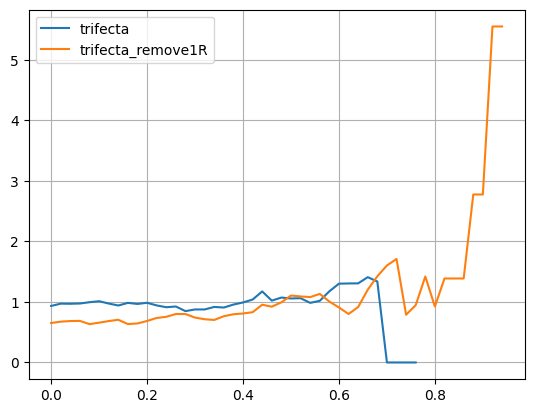

In [36]:
# グラフ表示
# plot(win_r1, 'win_r1')
# plot(win_r3, 'win_r3')
# plot(win_r1_remove1R, 'win_r1 remove1R')
# plot(exacta, 'exacta')
# plot(exacta_remove1R, 'exacta remove1R')
plot(trifecta, 'trifecta')
plot(trifecta_remove1R, 'trifecta_remove1R')


# 的中率
# plot_hit(gain_tansho, 'tansho')
# plot_hit(gain_fukusho, 'fukusho')
# plot_hit(gain_exacta, 'exacta')

# シャープレシオのプロット
# plot_sharpratio(gain_tansho, 'tansho')
# plot_sharpratio(gain_fukusho, 'tansho')

In [43]:

importlib.reload(mev)
result = mev.show_return_table(trifecta_ret, 0.6, False) # target, 確認したい閾値, False=あたってない購入も表示
print(len(result))
result

38


,trifecta,return,url
レースコード,,,
20220618BWK02,1-3-6,2140.0,https://www.boatrace.jp/owpc/pc/race/racelist?...
20220618BWK02,1-6-3,NaN,https://www.boatrace.jp/owpc/pc/race/racelist?...
20220707BWK05,1-2-3,1040.0,https://www.boatrace.jp/owpc/pc/race/racelist?...
20220707BWK05,1-3-2,NaN,https://www.boatrace.jp/owpc/pc/race/racelist?...
20220715BWK02,1-4-3,NaN,https://www.boatrace.jp/owpc/pc/race/racelist?...
20220715BWK02,1-3-4,NaN,https://www.boatrace.jp/owpc/pc/race/racelist?...
20220726BWK05,1-2-3,NaN,https://www.boatrace.jp/owpc/pc/race/racelist?...
20220726BWK05,1-3-2,NaN,https://www.boatrace.jp/owpc/pc/race/racelist?...
20220727BWK09,1-2-3,NaN,https://www.boatrace.jp/owpc/pc/race/racelist?...


## 回収率シュミレーション(全会場)

In [2332]:
# 全部の会場のgain関数をつくってみる
gain_dict = {}
for stadium in utils.stadium_list:
    gain = mev.Gain2(models, stadium, return_table.data_p, lower=0, n_samples=100)
    gain_dict[stadium] = gain

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.17it/s]


In [2335]:
# 会場ごとにシュミレーションを全部まわす

from tqdm import tqdm
met_dict = {}
for gain_key in gain_dict:
    gain = gain_dict[gain_key]
    win_r1, win_r1_ret = mev.win_r1_return(gain)
    win_r3, win_r3_ret = mev.win_r3_return(gain)
    win_r1_remove1R, win_r1_remove1R_ret = mev.win_r1_remove1R_return(gain)
    exacta, exacta_ret = mev.exacta_return(gain)
    exacta_remove1R, exacta_remove1R_ret = mev.exacta_remove1R_return(gain)
    trifecta, trifecta_ret = mev.trifecta_return(gain)
    trifecta_remove1R, trifecta_remove1R_ret = mev.trifecta_remove1R_return(gain)
    obj =  {
        'win_r1': win_r1,
        'win_r1_ret': win_r1_ret,
        'win_r3': win_r3,
        'win_r3_ret': win_r3_ret,
        'win_r1_remove1R': win_r1_remove1R,
        'win_r1_remove1R_ret': win_r1_remove1R_ret,
        'exacta': exacta,
        'exacta_ret': exacta_ret,
        'exacta_remove1R': exacta_remove1R,
        'exacta_remove1R_ret': exacta_remove1R_ret,
        'trifecta': trifecta,
        'trifecta_ret': trifecta_ret,
        'trifecta_remove1R': trifecta_remove1R,
        'trifecta_remove1R_ret': trifecta_remove1R_ret,
    }
    met_dict[gain_key] = obj
    

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.53it/s]


In [2346]:
utils.stadium_list.keys()


dict_keys(['KRY', 'TDA', 'EDG', 'HWJ', 'TMG', 'HMN', 'GMG', 'TKN', 'TSU', 'MKN', 'BWK', 'SME', 'AMG', 'NRT', 'MRG', 'KJM', 'MYJ', 'TKY', 'SMS', 'WKM', 'ASY', 'FKO', 'KRT', 'OMR'])

C:\Users\every\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


(0.0, 1.0)

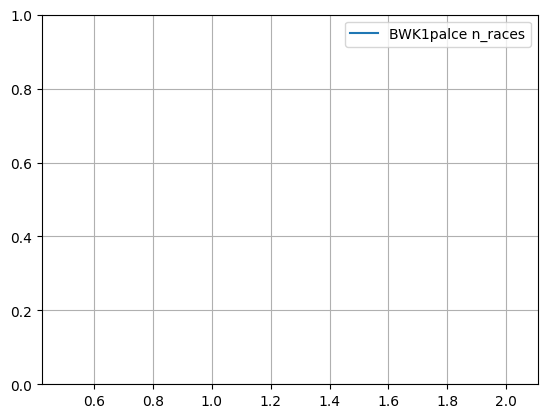

In [2671]:
# stadium_codes = ['KRY', 'TDA', 'EDG', 'HWJ', 'TMG', 'HMN']
# stadium_codes = ['GMG', 'TKN', 'TSU', 'MKN', 'BWK', 'SME']
# stadium_codes = ['AMG', 'NRT', 'MRG', 'KJM', 'MYJ', 'TKY']
stadium_codes = ['SMS', 'WKM', 'ASY', 'FKO', 'KRT', 'OMR']

# stadium_codes = ['EDG', 'HWJ', 'GMG', 'BWK', 'KRT']
stadium_codes = ['BWK'] #'HWJ', 'GMG', 'BWK', 'KRT']
for stadium in stadium_codes:
# for stadium in utils.stadium_list:
    met = met_dict[stadium]
    # plot_hit(met['win_r1'], stadium+' win r1', True)
    # plot(met['trifecta_remove1R'], stadium+' without1R', True)
    # plot(met['trifecta'], stadium+' 1R', True)
    # plot(met['trifecta_remove1R'], stadium+' without1R', True)
    # plot_hit(met['trifecta'], stadium+ '1R hit_rate')
    # plot_hit(met['trifecta_remove1R'], stadium+ 'wihtout1R hit_rate')
    # plot_sharpratio(met['trifecta'], stadium+' 1R ratio')
    # plot_sharpratio(met['trifecta_remove1R'], stadium+'without1R ratio')
    
    
    
    # plot_hit(met['win_r1'], stadium+' 1place hit_rate')
    # plot_hit(met['win_r1_remove1R'], stadium+' 1place without 1R hit_rate')
    plot_n_races(met['win_r1'], stadium+'1palce n_races') 
plt.ylim(top=2)
# plt.ylim(top=1)
# plt.ylim(bottom=0.9)
# plt.xlim(left=0.5)
# plt.ylim(bottom=1)

plt.ylim(top=1)
plt.ylim(bottom=0)

# plt.ylim(top=0.7)
# plt.ylim(bottom=0.5)

In [2674]:
met['win_r1'].n_races

0.50    1336.0
0.53    1336.0
0.56    1336.0
0.59    1336.0
0.62    1336.0
0.65    1336.0
0.68    1336.0
0.71    1336.0
0.74    1336.0
0.77    1335.0
0.80    1335.0
0.83    1335.0
0.86    1335.0
0.89    1335.0
0.92    1335.0
0.95    1335.0
0.98    1335.0
1.01    1335.0
1.04    1334.0
1.07    1334.0
1.10    1332.0
1.13    1330.0
1.16    1325.0
1.19    1322.0
1.22    1318.0
1.25    1313.0
1.28    1307.0
1.31    1299.0
1.34    1286.0
1.37    1280.0
1.40    1274.0
1.43    1267.0
1.46    1261.0
1.49    1251.0
1.52    1236.0
1.55    1227.0
1.58    1216.0
1.61    1202.0
1.64    1188.0
1.67    1163.0
1.70    1134.0
1.73    1096.0
1.76    1061.0
1.79    1017.0
1.82     979.0
1.85     921.0
1.88     832.0
1.91     708.0
1.94     565.0
1.97     409.0
2.00     251.0
2.03      55.0
Name: n_races, dtype: float64

In [2669]:
importlib.reload(mev)
result = mev.show_return_table(met_dict['BWK']['win_r1_remove1R_ret'], 0.6, True)
print(len(result))
result
# result[~(result['win'] == 1)]

65


,win,return,url
レースコード,,,
20220610BWK07,2,160.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=07&jcd=11&hd=20220610
20220611BWK06,2,210.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=06&jcd=11&hd=20220611
20220612BWK06,3,180.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=06&jcd=11&hd=20220612
20220617BWK02,3,260.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=02&jcd=11&hd=20220617
20220618BWK04,3,100.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=04&jcd=11&hd=20220618
20220619BWK03,3,1060.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=03&jcd=11&hd=20220619
20220621BWK08,3,260.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=08&jcd=11&hd=20220621
20220626BWK03,2,150.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=03&jcd=11&hd=20220626
20220627BWK09,2,260.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=09&jcd=11&hd=20220627


## 実験

In [1457]:
import syusso_table as sy
import utils 
importlib.reload(sy)
importlib.reload(utils)

syusso = sy.SyussoTable(race_results, '20230105', 'OMR')
syusso.test()

20230105OMR01 直前情報リクエスト済みなのでスキップ
20230105OMR02 直前情報リクエスト済みなのでスキップ
20230105OMR03 直前情報リクエスト済みなのでスキップ
20230105OMR04 直前情報リクエスト済みなのでスキップ
20230105OMR05 直前情報リクエスト済みなのでスキップ
20230105OMR06 直前情報リクエスト済みなのでスキップ
20230105OMR07 直前情報リクエスト済みなのでスキップ
20230105OMR08 直前情報リクエスト済みなのでスキップ
20230105OMR09 直前情報リクエスト済みなのでスキップ
20230105OMR10 直前情報リクエスト済みなのでスキップ
20230105OMR11 直前情報リクエスト済みなのでスキップ
20230105OMR12 直前情報リクエスト済みなのでスキップ
syusso_table:テスト成功


In [800]:
# レーサーの過去テーブル作成テスト用(出走テーブルのデータをもとに作るのが処理時間が短くて確認しやすい
import racer_table as racer_t
importlib.reload(racer_t)

# hoge = racer_t.RacerTable.create_from_syusso(data_tables.race_t, syusso.data)
hoge = racer_t.RacerTable.create_from_syusso(syusso.race_results.data, syusso.data)
hoge.data_p

レーサーの過去生成データテーブルの作成


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 69.25it/s]


,レースコード,艇番,全国_1着率_allR,全国_3着率_allR,全国_着順平均_allR,全国_スタートタイミング_allR,全国_展示タイム_allR,当地_1着率_allR,当地_3着率_allR,当地_着順平均_allR,...,当地_1着率_5R,当地_3着率_5R,当地_着順平均_5R,当地_スタートタイミング_5R,当地_展示タイム_5R,コース別_1着率_5R,コース別_3着率_5R,コース別_着順平均_5R,コース別_スタートタイミング_5R,コース別_展示タイム_5R
0,20230105OMR01,1,0.138122,0.464088,3.417127,0.188483,6.819607,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.4,1.0,1.8,0.170,6.758
50,20230105OMR09,3,0.137741,0.465565,3.413223,0.188263,6.819916,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.0,0.8,2.6,0.226,6.846
1,20230105OMR01,2,0.076923,0.381538,3.778462,0.155556,6.829630,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.2,0.6,3.0,0.124,6.848
66,20230105OMR12,1,0.076687,0.380368,3.779141,0.155785,6.829846,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.2,0.8,2.4,0.186,6.818
2,20230105OMR01,3,0.248101,0.521519,3.288608,0.150128,6.873189,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.2,0.6,3.0,0.206,6.920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,20230105OMR12,3,0.286972,0.702465,2.691901,0.152852,6.784683,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.6,1.0,1.8,0.174,6.806
46,20230105OMR08,5,0.139108,0.485564,3.425197,0.179474,6.799921,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.0,0.2,4.2,0.220,6.832
47,20230105OMR08,6,0.144165,0.443936,3.686499,0.131648,6.794371,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.0,0.4,4.4,0.128,6.740
53,20230105OMR09,6,0.171698,0.584906,3.232075,0.170586,6.821096,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.0,0.2,4.6,0.244,6.810


In [964]:
import numpy as np
def win_payoff_list(df):
    # retval = []
    df = df[  
            (df['単勝_艇番']==df['艇番']) | 
            (df['単勝_艇番']==-1)
        ].copy()
    
    df['return'] = df['単勝_払戻金']
    return df
    
# 単勝
def win_return(pred_table, return_table):
    n_bets = len(pred_table)
    n_races = pred_table.index.nunique()
    money = -100 * n_bets
    df = return_table.copy() 
    df = df.merge(pred_table, left_index=True, right_index=True, how='right')
    
    hit_df = win_payoff_list(df)
    
    n_hits = len(hit_df)
    money += hit_df['return'].sum()
    std = hit_df['return'].groupby(level=0).sum().std() * np.sqrt(n_races) / (100 * n_bets)
        
    return n_bets, money, n_hits, std

In [963]:
def place_payoff_list(df):
    place_1 = df[  
            (df['複勝_1着_艇番']==df['艇番']) | 
            (df['複勝_1着_艇番']==-1)
        ].copy()
    place_1['return'] = place_1['複勝_1着_払戻金']
    
    place_2 = df[df['複勝_2着_艇番']==df['艇番']].copy()
    place_2['return'] = place_2['複勝_2着_払戻金']
    
    return pd.concat([place_1, place_2])
    

# 複勝
def place_return(pred_table, return_table):
    n_bets = len(pred_table)
    n_races = pred_table.index.nunique()
    money = -100 * n_bets
    df = return_table.copy() 
    df = df.merge(pred_table, left_index=True, right_index=True, how='right')
    
    hit_df = place_payoff_list(df)
    
    n_hits = len(hit_df)
    money += hit_df['return'].sum()
    std = hit_df['return'].groupby(level=0).sum().std() * np.sqrt(n_races) / (100 * n_bets)

    return n_bets, money, n_hits, std

In [1094]:

#	                艇番 pred 　　　bet	  exacta 		
#   20220528OMR06	1	 1.300359	1	   1-3
#   .....
#　 の形のテーブルになる
def pred_table_exacta_top_2(pred_table):
    # 新しくpred_tableをコピーしexacta行をつける
    exacta_pred_table = pred_table.copy()
    exacta_pred_table['exacta'] = ''

    # レースコードの数だけ試行
    for race_code in exacta_pred_table.index.unique():

        # レースコードごとのpred_table
        race_pred_table = pred_table.filter(regex=race_code, axis=0)
        if(len(race_pred_table) >= 2):
            # print(race_pred_table.sort_values('pred', ascending=False))
            # pred値が高い順にソートし、top2つだけ選ぶ
            df = race_pred_table.sort_values('pred', ascending=False)[:2]
            exacta_bet = df['艇番'].tolist()

            exacta_bet_str = '-'.join(map(str, exacta_bet))
            data = [''] * len(race_pred_table)
            data[0] = exacta_bet_str
            exacta_pred_table.loc[race_code, 'exacta'] = data

    exacta_pred_table = exacta_pred_table[exacta_pred_table['exacta'] != '']
    return exacta_pred_table

# 2連単
def exacta_payoff_list2(df):
    retval = []
    
    func = lambda _: _.map(lambda x: '-'.join(map(str, x)))
    evaluate_func = lambda x, y: x in y.split(',') 
    
    winning = []
    for i, row in df.iterrows():
        winning.append(row['2連単_艇番'] in row['exacta'])
    df['winning'] = winning 
    retval.append(df[df['winning']]['2連単_払戻金'])
       
    retval.append(df[df['2連単_艇番'] == -1]['2連単_払戻金'])
    return retval

def exacta_payoff_list(df):
    exacta_1 = df[  
            (df['2連単_艇番']==df['exacta']) | 
            (df['2連単_艇番']==-1)
        ].copy()
    exacta_1['return'] = exacta_1['2連単_払戻金']
    
    return exacta_1

# 2連単
def exacta_return(pred_table, return_table, buy_func=pred_table_exacta_top_2):
    df = return_table.copy() 
    
    pred_table = buy_func(pred_table.copy())
    df = df.merge(pred_table, left_index=True, right_index=True, how='right')
    
    n_bets = len(df)
    n_races = df.index.nunique()
    
    hit_df = exacta_payoff_list(df)
    
    n_hits = len(hit_df)
    
    money = -100 * n_bets
    money += hit_df['return'].sum()
    
    std = hit_df['return'].groupby(level=0).sum().std() * np.sqrt(n_races) / (100 * n_bets)
    
    return n_bets, money, n_hits, std

In [1095]:
df = exacta_return(gain_t.pred_tables[0.8], return_table.data_p)
df

(96, -2530, 18, 0.167734528360613)

In [1578]:
def exacta_return(gain):
    # 1着以内に入るpred_table閾値決め打ちで作成
    threshold_r1 = -1
    for threshold in gain.pred_tables_r1:
        # print(threshold)
        if threshold > threshold_r1:
            pred_table_r1 = gain.pred_tables_r1[threshold]
            break

    # 3着以内に入るpred_tableについて閾値を決めて検証
    for threshold in tqdm(gain.pred_tables_r3):
        pred_table_r3 = gain.pred_tables_r3[threshold]
        exacta_buy_func(pred_table_r1, pred_table_r3)


        break
#         n_races = pred_table.index.nunique()

#         n_bets, money, n_hits, std = return_func(pred_table, self.return_table)
#         if n_bets > self.lower:
#             return_rate = (n_bets*100+money) / (n_bets*100)
#             gain[threshold] = {'return_rate' : return_rate,
#                             'n_hits': n_hits,
#                             'hit_rate': n_hits/n_races,
#                             'std' : std,
#                             'n_bets': n_bets} 


In [2095]:
importlib.reload(mev)
gain2 = mev.Gain2(models, 'BWK', return_table.data_p, lower=0, n_samples=100, t_range_r1 = [-0.5, 3], t_range_r3=[-0.5, 1])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.44it/s]


In [2064]:
importlib.reload(mev)
win_r1 = mev.win_r1_return(gain2)
win_r3 = mev.win_r3_return(gain2)
win_r1_remove1R = mev.win_r1_remove1R_return(gain2)
exacta = mev.exacta_return(gain2)
exacta_reveme1R = mev.exacta_remove1R_return(gain2)
trifecta = mev.trifecta_return(gain2)
trifecta_remove1R = mev.trifecta_remove1R_return(gain)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.35it/s]


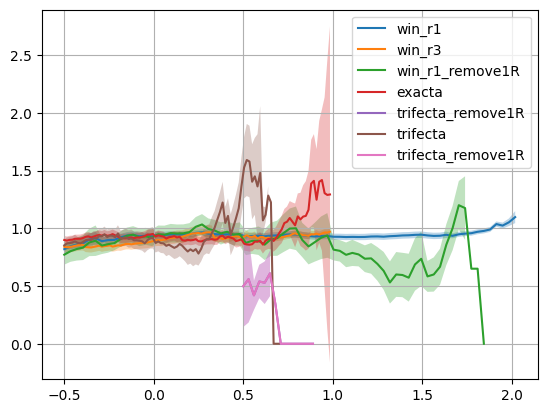

In [2065]:
plot(win_r1, 'win_r1')
plot(win_r3, 'win_r3')
plot(win_r1_remove1R, 'win_r1_remove1R')
plot(exacta, 'exacta')
plot(trifecta_remove1R, 'trifecta_remove1R')
plot(trifecta, 'trifecta')
plot(trifecta_remove1R, 'trifecta_remove1R')

In [2270]:
importlib.reload(mev)
win_r1, pred = mev.exacta_return(gain2)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.71it/s]


In [2271]:
df = pred[-0.410]
df[~df['return'].isna()]

,exacta,return,url
レースコード,,,
20220526BWK10,1-3,1460.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=10&jcd=11&hd=20220526
20220608BWK01,1-3,490.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=01&jcd=11&hd=20220608
20220608BWK04,1-2,520.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=04&jcd=11&hd=20220608
20220608BWK05,1-2,290.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=05&jcd=11&hd=20220608
20220608BWK06,1-4,270.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=06&jcd=11&hd=20220608
...,...,...,...
20230106BWK10,1-4,280.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=10&jcd=11&hd=20230106
20230106BWK11,1-5,480.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=11&jcd=11&hd=20230106
20230107BWK06,1-2,1120.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=06&jcd=11&hd=20230107


In [2295]:
show_return_table(pred, 0.8)

,exacta,return,url
レースコード,,,
20220608BWK04,1-2,520.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=04&jcd=11&hd=20220608
20220610BWK10,1-2,170.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=10&jcd=11&hd=20220610
20220611BWK02,1-2,830.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=02&jcd=11&hd=20220611
20220619BWK05,1-3,110.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=05&jcd=11&hd=20220619
20220622BWK05,1-3,210.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=05&jcd=11&hd=20220622
20220626BWK05,1-2,160.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=05&jcd=11&hd=20220626
20220630BWK01,1-2,260.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=01&jcd=11&hd=20220630
20220701BWK07,1-2,290.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=07&jcd=11&hd=20220701
20220706BWK05,1-2,150.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=05&jcd=11&hd=20220706


In [2243]:
create_win_return_list(test, return_table)

,win,return,url
レースコード,,,
20220526BWK09,1,150.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=09&jcd=11&hd=20220526
20220526BWK09,2,NaN,https://www.boatrace.jp/owpc/pc/race/racelist?rno=09&jcd=11&hd=20220526
20220526BWK09,3,NaN,https://www.boatrace.jp/owpc/pc/race/racelist?rno=09&jcd=11&hd=20220526
20220526BWK09,5,NaN,https://www.boatrace.jp/owpc/pc/race/racelist?rno=09&jcd=11&hd=20220526
20220526BWK10,1,130.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=10&jcd=11&hd=20220526
...,...,...,...
20230107BWK11,4,NaN,https://www.boatrace.jp/owpc/pc/race/racelist?rno=11&jcd=11&hd=20230107
20230107BWK11,2,NaN,https://www.boatrace.jp/owpc/pc/race/racelist?rno=11&jcd=11&hd=20230107
20230107BWK12,1,100.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=12&jcd=11&hd=20230107


In [2231]:
df[~df['return'].isna()]

,win,return,url
レースコード,,,
20220526BWK09,1,150.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=09&jcd=11&hd=20220526
20220526BWK10,1,130.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=10&jcd=11&hd=20220526
20220526BWK11,1,200.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=11&jcd=11&hd=20220526
20220526BWK12,3,920.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=12&jcd=11&hd=20220526
20220608BWK01,1,100.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=01&jcd=11&hd=20220608
...,...,...,...
20230107BWK08,2,910.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=08&jcd=11&hd=20230107
20230107BWK09,1,110.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=09&jcd=11&hd=20230107
20230107BWK10,1,110.0,https://www.boatrace.jp/owpc/pc/race/racelist?rno=10&jcd=11&hd=20230107


In [2224]:
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_colwidth", 100)


In [2135]:
bet_t = pd.merge(gain2.pred_table_r1_all.drop(['bet'], axis=1), test.drop(['pred', 'bet'], axis=1), on=['艇番', 'レースコード'], how='left')#[['艇番', 'pred']]

In [2136]:
bet_t.head(20)

,艇番,pred,win
レースコード,,,
20220526BWK09,1,1.992025,1.0
20220526BWK09,4,-0.511962,NaN
20220526BWK09,2,-0.384635,2.0
20220526BWK09,3,0.002481,3.0
20220526BWK09,6,-0.646624,NaN
20220526BWK09,5,-0.451285,5.0
20220526BWK10,1,1.970625,1.0
20220526BWK10,3,-0.270445,3.0
20220526BWK10,4,-0.264417,4.0


In [2115]:
pd.merge(bet_t.groupby(level=0), race_results.data_p, on=['レースコード'], how='left')

TypeError: Can only merge Series or DataFrame objects, a <class 'pandas.core.groupby.generic.DataFrameGroupBy'> was passed

In [ ]:
models

In [2041]:
hoge_tri_remove1R = gain2.trifecta_remove1R_return()
hoge_exa_remove1R = gain2.exacta_remove1R_return()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.37it/s]


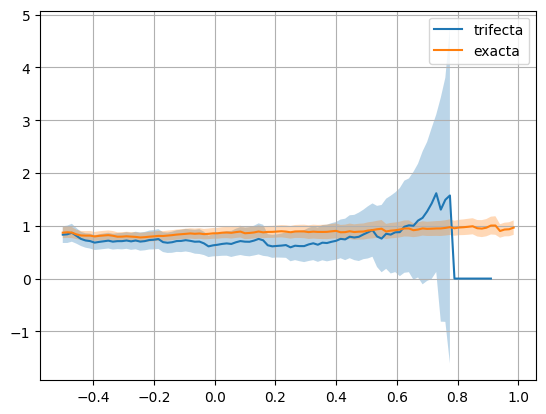

In [2042]:
plot(hoge_tri_remove1R, 'trifecta')
plot(hoge_exa_remove1R, 'exacta')

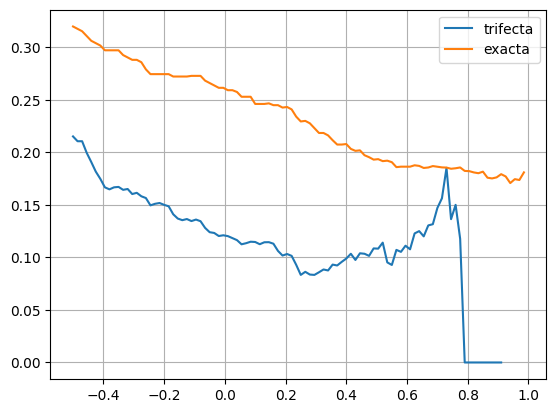

In [2043]:
plot_hit(hoge_tri_remove1R, 'trifecta')
plot_hit(hoge_exa_remove1R, 'exacta')

In [2037]:
hoge_tri_remove1R[hoge_tri_remove1R['hit_rate']>0.15]

,return_rate,n_hits,n_races,hit_rate,std,n_bets
-0.500,0.831980,94.0,437.0,0.215103,0.158101,2858.0
-0.485,0.838653,92.0,437.0,0.210526,0.164204,2776.0
-0.470,0.868046,92.0,437.0,0.210526,0.169959,2682.0
-0.455,0.809279,87.0,436.0,0.199541,0.147945,2608.0
-0.440,0.751332,83.0,435.0,0.190805,0.134818,2552.0
-0.425,0.721898,79.0,435.0,0.181609,0.136778,2498.0
-0.410,0.710123,76.0,435.0,0.174713,0.141672,2440.0
-0.395,0.681008,72.0,432.0,0.166667,0.139480,2380.0
-0.380,0.694826,71.0,431.0,0.164733,0.145190,2300.0
-0.365,0.706499,71.0,426.0,0.166667,0.146771,2262.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


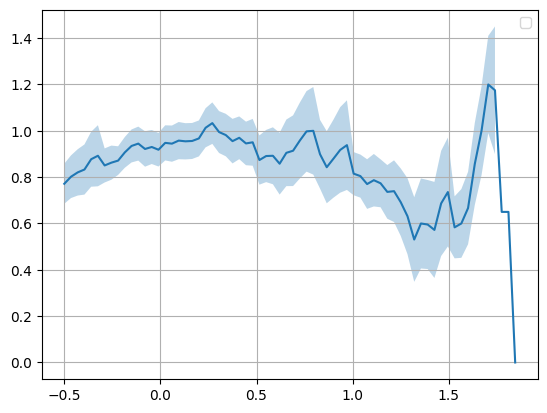

In [2015]:
plot(hoge_win_r1_remove_1)

In [2019]:
hoge_win_r1_remove_1[hoge_win_r1_remove_1['hit_rate'] > 0.4]

,return_rate,n_hits,n_races,hit_rate,std,n_bets
0.235,1.013115,178.0,441.0,0.403628,0.084444,488.0
0.270,1.033185,168.0,404.0,0.415842,0.089624,449.0
0.305,0.994673,151.0,373.0,0.404826,0.090444,413.0
0.340,0.981671,139.0,337.0,0.412463,0.091713,371.0
0.375,0.955457,127.0,312.0,0.407051,0.096157,339.0
0.410,0.969872,121.0,288.0,0.420139,0.092306,312.0
0.445,0.945520,109.0,260.0,0.419231,0.094022,279.0
0.480,0.950397,100.0,235.0,0.425532,0.101038,252.0
0.515,0.873932,88.0,217.0,0.405530,0.106278,234.0
0.550,0.891163,83.0,201.0,0.412935,0.112724,215.0


In [2007]:
hoge_win_r1 = gain2.win_r1_return()
hoge_win_r3 = gain2.win_r3_return()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.52it/s]


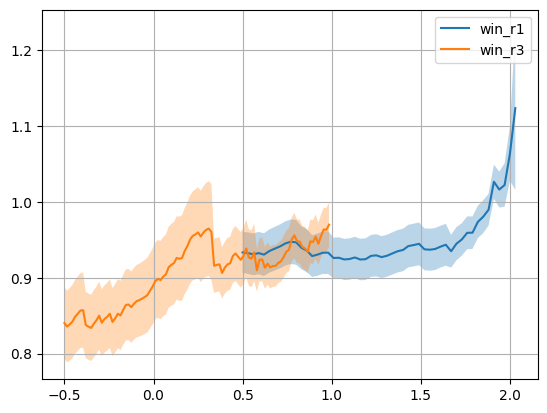

In [2008]:
plot(hoge_win_r1, 'win_r1')
plot(hoge_win_r3, 'win_r3')

In [2002]:
hoge_win_r1[hoge_win_r1['return_rate'] > 0.95]

,return_rate,n_hits,n_races,hit_rate,std,n_bets
1.73,0.950456,683.0,1096.0,0.623175,0.021389,1096.0
1.76,0.959189,670.0,1061.0,0.631480,0.021686,1061.0
1.79,0.959390,648.0,1017.0,0.637168,0.021422,1017.0
1.82,0.973647,639.0,979.0,0.652707,0.021390,979.0
1.85,0.980456,611.0,921.0,0.663409,0.021685,921.0
1.88,0.989663,568.0,832.0,0.682692,0.020944,832.0
1.91,1.026554,508.0,708.0,0.717514,0.022511,708.0
1.94,1.016283,412.0,565.0,0.729204,0.023730,565.0
1.97,1.022249,303.0,409.0,0.740831,0.028704,409.0
2.00,1.063745,196.0,251.0,0.780876,0.035752,251.0


In [2004]:
hoge_exacta = gain2.exacta_return()
hoge_tri = gain2.trifecta_return()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.98it/s]


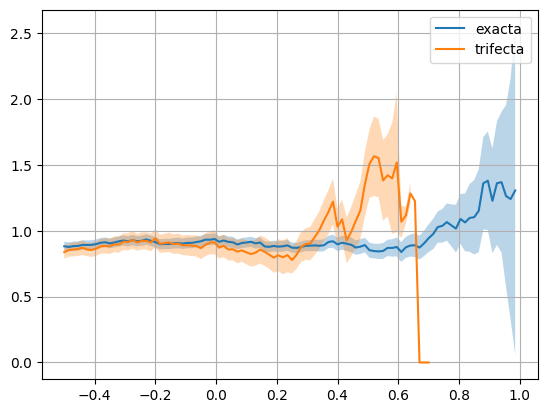

In [2005]:
plot(hoge_exacta, 'exacta')
plot(hoge_tri, 'trifecta')

In [2006]:
hoge_tri[hoge_tri['return_rate'] > 1]

,return_rate,n_hits,n_races,hit_rate,std,n_bets
0.340,1.004398,51.0,210.0,0.242857,0.142917,432.0
0.355,1.077344,49.0,190.0,0.257895,0.155493,384.0
0.370,1.142529,46.0,174.0,0.264368,0.166259,348.0
0.385,1.221192,44.0,151.0,0.291391,0.174554,302.0
0.400,1.030078,35.0,128.0,0.273438,0.138731,256.0
0.415,1.086957,33.0,115.0,0.286957,0.150507,230.0
0.460,1.074074,24.0,81.0,0.296296,0.201963,162.0
0.475,1.153521,23.0,71.0,0.323944,0.217246,142.0
0.490,1.351724,22.0,58.0,0.379310,0.246012,116.0
0.505,1.507692,22.0,52.0,0.423077,0.259818,104.0


In [1985]:
gain2.n_all_races

1336

In [1986]:
63/gain2.n_all_races

0.04715568862275449

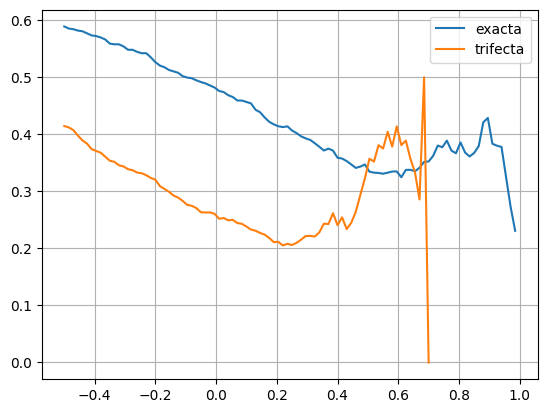

In [1987]:
plot_hit(hoge, 'exacta')
plot_hit(hoge_tri, 'trifecta')

In [1961]:
importlib.reload(mev)
gain2 = mev.Gain2(models, 'BWK', return_table.data_p, lower=0, n_samples=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.34it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.72it/s]


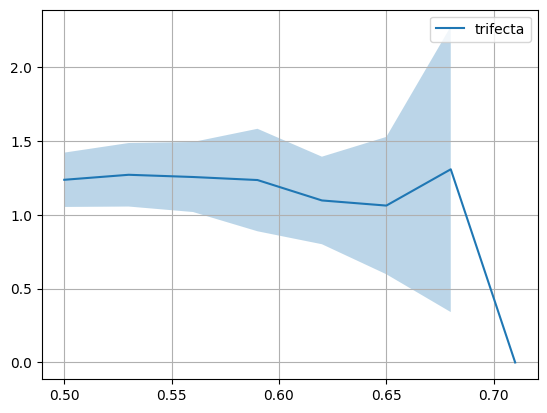

In [1964]:
plot(hoge_tri, 'trifecta')

In [1938]:
gain2.n_all_races

1336

In [1959]:
# 3連単
def trifecta_payoff_list(df):
    trifecta_1 = df[  
            (df['3連単_艇番']==df['trifecta']) | 
            (df['3連単_艇番']==-1) |
            (df['3連単_艇番']==-2)
        ].copy()
    trifecta_1['return'] = trifecta_1['3連単_払戻金']
    
    return trifecta_1

# 3連単
def trifecta_return_new(pred_table, return_table):
    n_bets = len(pred_table)
    n_races = pred_table.index.nunique()
    money = -100 * n_bets
    df = return_table.copy() 
    df = df.merge(pred_table, left_index=True, right_index=True, how='right')
    
    hit_df = trifecta_payoff_list(df)
    
    n_hits = len(hit_df)
    money += hit_df['return'].sum()
    std = hit_df['return'].groupby(level=0).sum().std() * np.sqrt(n_races) / (100 * n_bets)
    
    return n_bets, money, n_hits, std



In [1960]:
trifecta_return_new(df, return_table.data_p)

(172, 4080, 30, 0.18395946638136845)

In [1926]:
r3

,艇番,pred,bet
レースコード,,,
20220815BWK01,1,2.010872,1
